SSD Object Detection .


In [ ]:
pip install torch torchvision


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.detection import ssd300_vgg16
import xml.etree.ElementTree as ET
import os


In [ ]:
!rm -rf "data"

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load PASCAL VOC Dataset
voc_train = datasets.VOCDetection(root='./data/VOC',
                                  year='2012',
                                  image_set='train',
                                  download=True,
                                  transform=transform)



100%|██████████| 1999639040/1999639040 [02:45<00:00, 12095089.14it/s]


Extracting ./data/VOC/VOCtrainval_11-May-2012.tar to ./data/VOC


In [ ]:
label_map = {
    'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4,
    'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9,
    'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13,
    'motorbike': 14, 'person': 15, 'pottedplant': 16,
    'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20
}

def parse_voc_annotations(target, label_map):
    annotation_file = target['annotation']
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    boxes = []
    labels = []
    for obj in root.iter('object'):
        label = obj.find('name').text
        if label not in label_map:
            continue
        labels.append(label_map[label])

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])

    return {'boxes': torch.as_tensor(boxes, dtype=torch.float32), 'labels': torch.as_tensor(labels, dtype=torch.int64)}









In [ ]:
data_dir = '/content/data/VOC/VOCdevkit/VOC2012'  # Adjust this path as necessary

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [parse_voc_annotations(item[1], label_map) for item in batch]
    return images, targets

train_loader = torch.utils.data.DataLoader(voc_train, batch_size=4, shuffle=True, collate_fn=collate_fn)


In [ ]:
import torch
import torchvision.models.detection as detection_models
import torchvision.models.detection.ssd as ssd_models

num_classes = 21  # 20 classes + background for PASCAL VOC

# Load the pre-trained SSD model
pretrained_model = detection_models.ssd300_vgg16(pretrained=True)

# Create a new SSD model with the desired number of classes
model = detection_models.ssd300_vgg16(pretrained=False, num_classes=num_classes)

# Copy weights from the pre-trained model, excluding the classification head
pretrained_state_dict = pretrained_model.state_dict()
new_state_dict = model.state_dict()

for key in pretrained_state_dict:
    if 'classification_head' not in key:
        new_state_dict[key] = pretrained_state_dict[key]

model.load_state_dict(new_state_dict)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import box_iou


class SSDLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(SSDLoss, self).__init__()
        self.alpha = alpha
        self.localization_loss = nn.SmoothL1Loss(reduction='none')
        self.confidence_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predictions, targets):
        loc_preds, cls_preds = predictions
        loc_targets = []
        cls_targets = []

        for target in targets:
            loc_targets.append(target['boxes'])
            cls_targets.append(target['labels'])

        loc_targets = torch.cat(loc_targets, 0)
        cls_targets = torch.cat(cls_targets, 0)

        pos_mask = cls_targets > 0

        # Localization Loss
        loc_loss = self.localization_loss(loc_preds[pos_mask], loc_targets[pos_mask])
        loc_loss = loc_loss.sum()

        # Confidence Loss
        cls_loss = self.confidence_loss(cls_preds.view(-1, cls_preds.size(-1)), cls_targets.view(-1))
        cls_loss = cls_loss.sum()

        # Total Loss
        total_loss = loc_loss + self.alpha * cls_loss

        return total_loss


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
def calculate_accuracy(preds, targets, iou_threshold=0.5):
    total = 0
    correct = 0

    # Loop through all predictions and targets
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        target_boxes = target['boxes']
        target_labels = target['labels']

        ious = box_iou(pred_boxes, target_boxes)

        for i, pred_label in enumerate(pred_labels):
            # Find the best matching ground truth box
            best_iou, best_target_idx = ious[i].max(0)
            if best_iou >= iou_threshold and pred_label == target_labels[best_target_idx]:
                correct += 1
            total += 1

    return correct / total if total > 0 else 0




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 2
data_dir = '/content/data/VOC/VOCdevkit/VOC2012'  # Adjust this path as necessary


# Initialize the loss function
ssd_loss = SSDLoss()







In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass with both images and targets
        loss_dict = model(images, targets)

        # The model returns a dictionary of losses
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Backward pass and optimize
        losses.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')




##Running a Pretrained YOLO Model

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repository



In [ ]:
%cd yolov5
!pip install -r requirements.txt  # Install dependencies

In [ ]:
# Download weights (small model as an example)
#!wget https://github.com/ultralytics/yolov5/releases/download/v6.0/yolov5s.pt


In [ ]:
import torch
from IPython.display import Image  # for displaying images

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


In [ ]:
from google.colab import files
uploaded = files.upload()

# Check if the image is uploaded successfully
print("Uploaded files:", uploaded.keys())



Saving two_dogs.jpg to two_dogs.jpg
Uploaded files: dict_keys(['two_dogs.jpg'])


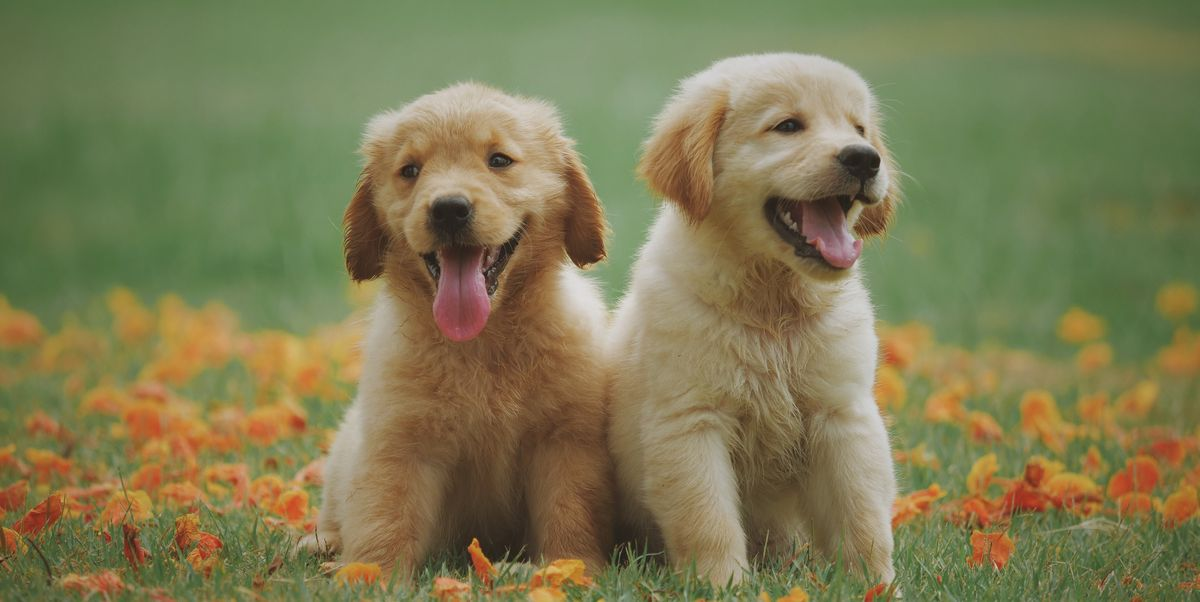

In [ ]:
from PIL import Image as PILImage
import io
from IPython.display import Image, display

# Assuming you uploaded one image, get its file name
image_path = next(iter(uploaded))

# Load the image using PIL
image = PILImage.open(io.BytesIO(uploaded[image_path]))

# Display the image to verify it's loaded correctly
display(image)


image 1/1: 602x1200 2 dogs
Speed: 11.5ms pre-process, 281.9ms inference, 1.1ms NMS per image at shape (1, 3, 352, 640)
Saved 1 image to runs/detect/exp2


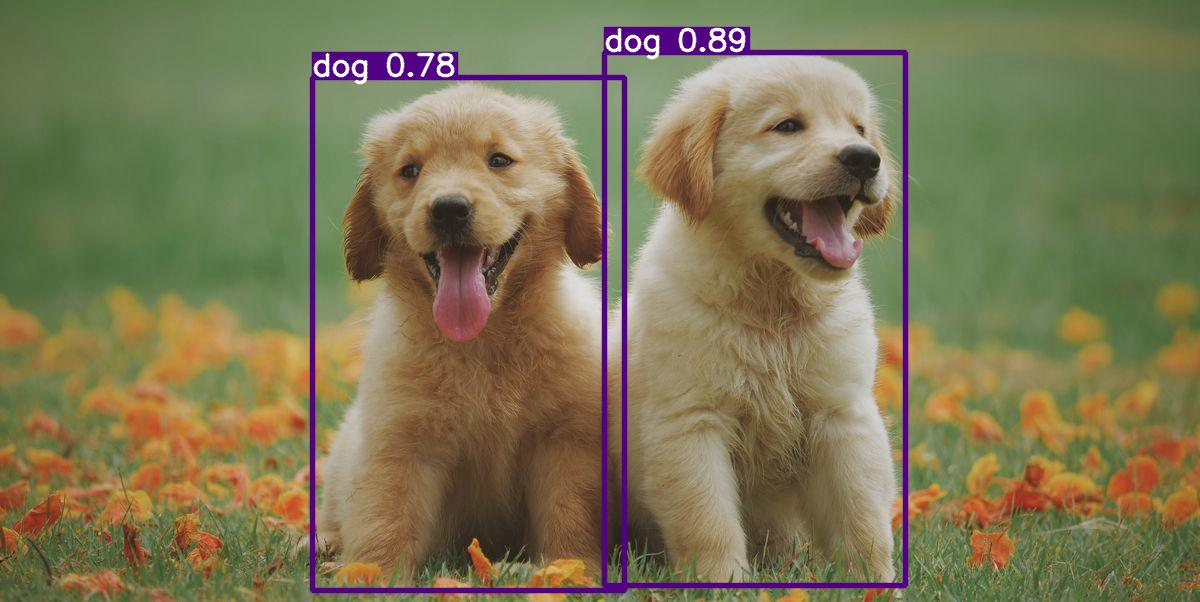

In [ ]:
import os

# Perform inference
results = model(image)

# Results are saved in 'results' object. We can print or save them
results.print()  # Print textual results
results.save()   # Save the image with bounding boxes

# Display the saved image
output_image_path = os.path.join('runs/detect/exp', 'image0.jpg')  # YOLOv5 saves as 'image0.jpg'
display(Image(output_image_path))



##Image Segmentation

In [ ]:
!pip install torch torchvision


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

!wget http://images.cocodataset.org/zips/val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip




--2023-12-22 05:06:11--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.29.101, 52.217.92.228, 52.217.115.129, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.29.101|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.0MB/s    in 6m 43s  

2023-12-22 05:12:54 (45.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-12-22 05:12:54--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.21.13, 3.5.3.112, 52.216.210.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.21.13|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  47.8MB/

In [ ]:
!unzip train2017.zip -d .
!unzip val2017.zip -d .
!unzip annotations_trainval2017.zip -d .


Visualizing Datatset

In [ ]:
!pip install pycocotools matplotlib pillow


In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io
from PIL import Image, ImageDraw


In [ ]:
dataDir = '/content/val2017'
dataType = 'val2017'
annFile = f'/content/annotations/instances_val2017.json'

# Initialize COCO API for instance annotations
coco = COCO(annFile)


loading annotations into memory...
Done (t=2.63s)
creating index...
index created!


In [ ]:
import numpy as np
import random

# Load the categories
cats = coco.loadCats(coco.getCatIds())

cat_names = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(cat_names)))

# Get image id and load an image
imgIds = coco.getImgIds(catIds=coco.getCatIds(cat_names))
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
image = io.imread(f'{dataDir}/{dataType}/{img["file_name"]}')

# Load and display instance annotations
plt.imshow(image); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=coco.getCatIds(), iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.show()


In [ ]:
# Load the categories
cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(cat_names)))

# Check if specific categories exist
specific_cats = ['cat', 'dog']  # Example categories
specific_cat_ids = coco.getCatIds(catNms=specific_cats)
print('Specific category IDs:', specific_cat_ids)


COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

Specific category IDs: [17, 18]


In [ ]:
# Get image ids for specific categories
imgIds = coco.getImgIds(catIds=specific_cat_ids)

# Check if the list is empty
if not imgIds:
    raise ValueError("No images found for the specified categories.")




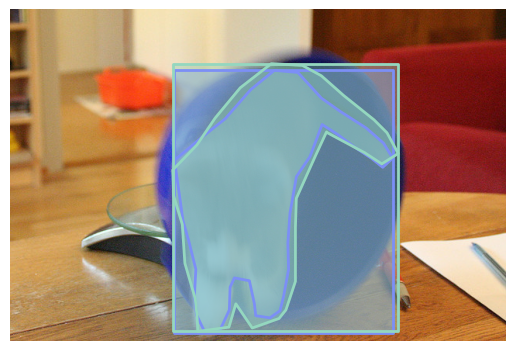

In [ ]:
# Select a random image id
img_id = random.choice(imgIds)

# Load the image
img = coco.loadImgs(img_id)[0]

# Load and display the image and annotations
image = io.imread(f'{dataDir}/{img["file_name"]}')
plt.imshow(image); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=specific_cat_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.show()


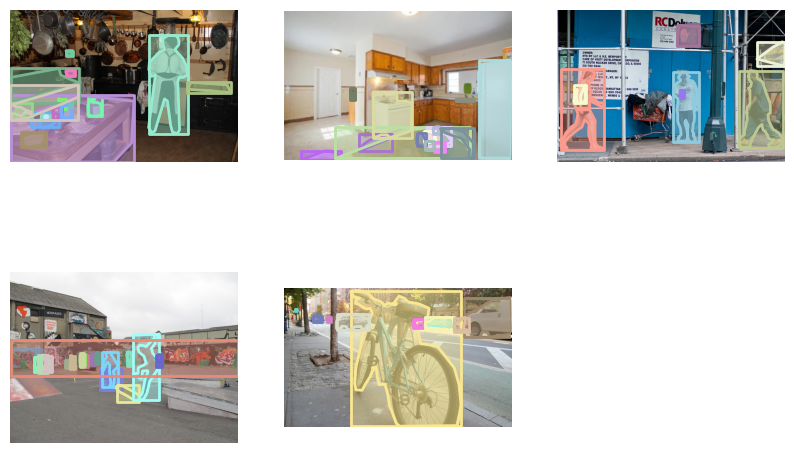

In [ ]:
# Define the number of images and grid size
num_images = 5
grid_size = 3

# Get all image ids
imgIds = coco.getImgIds()
imgIds = imgIds[:num_images]

# Create a figure with sub-plots
plt.figure(figsize=(10, 10))

for idx, imgId in enumerate(imgIds, 1):
    # Load the image
    img = coco.loadImgs(imgId)[0]
    image = io.imread(f'{dataDir}/{img["file_name"]}')

    # Load and display instance annotations
    plt.subplot(grid_size, grid_size, idx)
    plt.imshow(image); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns, draw_bbox=True)

plt.show()


##Training Code

In [ ]:
from pycocotools.coco import COCO
from pycocotools.mask import decode, frPyObjects  # Import frPyObjects as well
import numpy as np
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.datasets import CocoDetection
import torchvision.transforms as T

from pycocotools import mask as maskUtils


def get_transform(train):
    transforms = [T.ToTensor()]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def process_coco_annotations(annotations, image_info):
    boxes = []
    labels = []
    masks = []

    for annotation in annotations:
        if 'bbox' not in annotation or 'category_id' not in annotation:
            continue
        if 'segmentation' not in annotation or not annotation['segmentation']:
            continue

        x_min, y_min, width, height = annotation['bbox']
        boxes.append([x_min, y_min, x_min + width, y_min + height])
        labels.append(annotation['category_id'])

        segmentation = annotation['segmentation']
        if isinstance(segmentation, list):
            # Convert polygon to RLE
            rle = maskUtils.frPyObjects(segmentation, image_info['height'], image_info['width'])
            rle = maskUtils.merge(rle)
            mask = maskUtils.decode(rle)
        elif isinstance(segmentation, dict) and 'counts' in segmentation:
            rle = segmentation
            if isinstance(rle['counts'], list):
                # Convert counts from list to UTF-8 encoded byte string
                rle['counts'] = maskUtils.encode(np.asfortranarray(mask)).get('counts')
                if isinstance(rle['counts'], list):
                    # Convert list of integers to bytes
                    rle['counts'] = ''.join([chr(x) for x in rle['counts']])
            mask = maskUtils.decode(rle)
        else:
            continue

        if len(mask.shape) == 3:
            mask = mask[..., 0]
        masks.append(mask)

    if not masks:
        return None

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    masks = torch.stack([torch.as_tensor(m, dtype=torch.uint8) for m in masks])

    return {'boxes': boxes, 'labels': labels, 'masks': masks}



class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile, transform)
        self.coco = COCO(annFile)

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        if not annotations:
            print(f"Warning: No annotations found for image id {img_id}")
            return img, None

        image_info = self.coco.loadImgs(img_id)[0]
        target = process_coco_annotations(annotations, image_info)

        if target is None:
            print(f"Warning: No valid target found for image id {img_id}")
            return img, None

        return img, target

# Model creation and training loop remain the same


In [ ]:
# Model creation
def create_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = MaskRCNN(backbone, num_classes)
    return model

num_classes = 91  # 90 classes + background
model = create_model(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

dataDir = 'path_to_coco_dataset'
train_dataset = CocoDataset(root=f'train2017',
                            annFile=f'annotations/instances_train2017.json',
                            transform=get_transform(train=True))

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

num_epochs = 10
losses = []

loading annotations into memory...
Done (t=15.46s)
creating index...
index created!
loading annotations into memory...
Done (t=18.98s)
creating index...
index created!


In [ ]:
num_epochs = 1
losses = []

for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        if not images or not targets:
            continue

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets if t is not None]

        if not targets:
            continue

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses)}')